# Import Library

In [1]:
import pandas as pd
import json
import tensorflow as tf
import os
import re
import shutil
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
import keras.backend as K
keras = tf.keras


# Create Dataframe with image paths and captions

In [2]:
# Define the path prefix for the images
image_path_prefix = "../data/train2017"

# Load data from the JSON file
with open('../data/selected_data_10000.json', 'r') as json_file:
    data = json.load(json_file)

image_paths = []
captions = []

# Create image paths and captions using a loop
for item in data:
    image_id = item["image_id"]
    img_name = '%012d.jpg' % image_id
    image_path = f"{image_path_prefix}/{img_name}"
    caption = item["caption"]

    image_paths.append(image_path)
    captions.append(caption)

df = pd.DataFrame({'image': image_paths, 'caption': captions})
df.head(5)


FileNotFoundError: [Errno 2] No such file or directory: '../data/selected_data_10000.json'

# Data Cleaning

In [5]:
def cleaning(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespaces
    text = re.sub('\s+', ' ', text)
    # Remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Remove leading and trailing whitespaces
    text = text.strip()
    # Add start and end tokens
    text = '[start] ' + text + ' [end]'
    return text

In [6]:
# Apply data cleaning to the captions column
df['caption'] = df['caption'].apply(cleaning)
df.head()

,image,caption
0,../data/train2017/000000006846.jpg,[start] an old man riding a ox and pulling a w...
1,../data/train2017/000000358113.jpg,[start] a small boy laying on the ground with ...
2,../data/train2017/000000023025.jpg,[start] a girl in a striped shirt looks at a l...
3,../data/train2017/000000481971.jpg,[start] a woman throwing an object into a yell...
4,../data/train2017/000000306219.jpg,[start] dog riding on the back of a bicycle on...


# Display images with captions

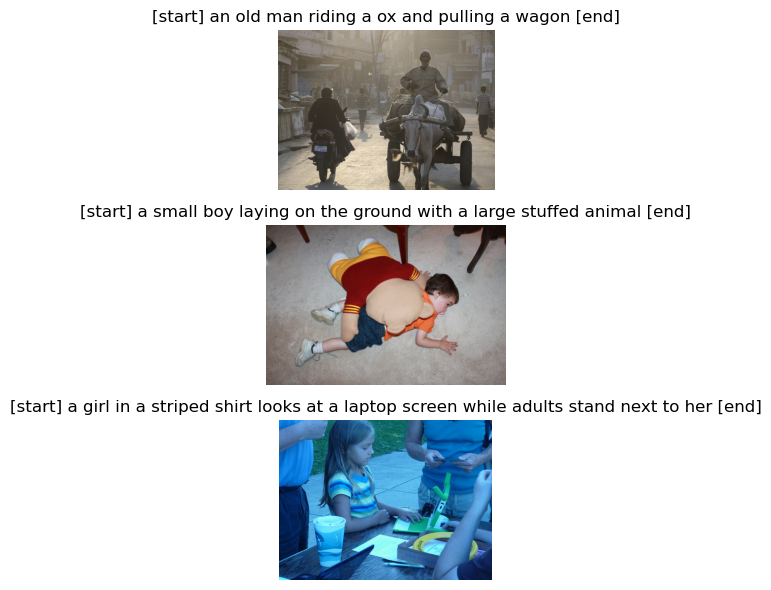

In [7]:
# Display some images and captions
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

for ax, (image_path, caption) in zip(axes.flatten(), zip(df['image'][:3], df['caption'][:3])):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(caption)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Split the data

In [37]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Reset the index for each subset
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Display the sizes of each subset
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 8000
Validation set size: 1000
Test set size: 1000


# Setting parameters

In [39]:
max_cap_len = 15  # Determines max length of captioning sentences
img_dimension = 299 # Determines the height and width of images
num_words = 10000 # Determines vocab size to tokenize and train on
encoding_size = 256 # Determines dimension of the encodings of images
LSTM_size = 768 
batch_size = 64
n_epochs = 15
Buffer_size = 1000
validation_and_test_split = 0.2
test_to_val_split = 0.5
num_examples = None 

# Tokenizing and padding captions

In [59]:
# # Create and fit the Tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words = num_words,filters ="!?,'()_-+=&*$#@.",oov_token="")
tokenizer.fit_on_texts(train_df["caption"])
# Convert captions to sequences of integers
captions_train = tokenizer.texts_to_sequences(train_df["caption"])
# Pad sequences to a fixed length
captions_train = keras.preprocessing.sequence.pad_sequences(captions_train, padding='post',maxlen=max_cap_len + 2)

if num_words == None:
  words = len(tokenizer.word_index)
else:
  words = num_words
print("Unique words:", words)

# Print a few examples of original captions and their padded sequences
num_examples_to_print = 2
for i in range(num_examples_to_print):
    random_example_index = np.random.randint(low=0, high=len(captions_train) - 1, size=1)[0]
    original_caption = train_df["caption"].iloc[random_example_index]
    padded_sequence = captions_train[random_example_index]

    print(f"Original Caption: {original_caption}")
    print(f"Padded Sequence: {padded_sequence}")
    print("\n")
     

Unique words: 10000
Original Caption: [start] a woman is swinging a racket at a ball [end]
Padded Sequence: [  3   2  15  12 140   2 111  16   2  39   4   0   0   0   0   0   0]


Original Caption: [start] a woman looks through the hole of a small cookie while at a restuarant [end]
Padded Sequence: [   3    2   15  295  100    6 2121    8    2   65  997   36   16    2
 3993    4    0]




In [41]:
# val dataset
captions_valid = tokenizer.texts_to_sequences(val_df["caption"])
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

# Preprocessing

In [43]:
# load images
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image
  img = tf.image.resize(img, (img_dimension, img_dimension))
  return img

In [44]:
def preprocess_func(path_index, caption):
  # read the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(train_df["image"],indices=path_index)
  img = load_img(path)#/255.0
  # preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  # initialize hidden and cell states with zeros
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [45]:
def preprocess_func_val(path_index, caption):
  # read the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(val_df["image"],indices=path_index)
  img = load_img(path)#/255.0
  # preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  # initialize hidden and cell states with zeros
  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [46]:
# creating an array to index each img path for reading 
path_index_vec_train = np.array(list(range(0,len(train_df["image"])))).reshape(-1,1)
path_index_vec_val = np.array(list(range(0,len(val_df["image"])))).reshape(-1,1)

dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train)
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train)
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train))
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [47]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256).prefetch(1)

# Building the model

In [71]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
# Load InceptionV3 with pre-trained weights and freeze layers
incep = keras.applications.inception_v3.InceptionV3(input_shape=(img_dimension,img_dimension,3),
                                                    include_top=False)
incep.trainable=False

In [50]:
# Input layers
img = keras.layers.Input(shape=(img_dimension,img_dimension,3))
teacher_forcing = keras.layers.Input(shape=(max_cap_len+1))
initial_state = keras.layers.Input(shape=(LSTM_size))
# Preprocess image input
img_preprocessed = preprocess_input(img)
# Encode image using InceptionV3
encoding = incep(img_preprocessed)
encoding_layer = keras.layers.Dense(encoding_size, activation='relu') # Encodes image
encoding = encoding_layer(encoding) # encodings shape is (8,8,encoding_size)
encoding = keras.layers.Flatten()(encoding)
# Repeat the encoding for each time step in the caption
repeater = keras.layers.RepeatVector(max_cap_len+1)
encoding = repeater(encoding)
# Embedding layer for teacher forcing input
embedding_layer = keras.layers.Embedding(words+1, 256, mask_zero=True)
dropout_on_embbeds = keras.layers.Dropout(0.15)

embedds = embedding_layer(teacher_forcing)
embedds = dropout_on_embbeds(embedds)
# Concatenate the encoded image and embedded teacher forcing input
conc = keras.layers.Concatenate()
# LSTM layer for decoding
decoder_lstm_layer = keras.layers.LSTM(LSTM_size,return_sequences=True,return_state=True,dropout=0.2)
# Dense layer for output
decoder_dense_layer = keras.layers.Dense(words + 1, activation=None, name='output_layer')

h = initial_state
c = initial_state

decoder_lstm_input = conc([encoding, embedds])
  
lstm_out , h , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(lstm_out)

model = keras.models.Model([img,initial_state,teacher_forcing],out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 299, 299, 3)  0           ['input_3[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 299, 299, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 inception_v3 (Functional)      (None, 8, 8, 2048)   21802784    ['tf.math.subtract[0][0]']   

In [73]:
# loss function
def sparse_it_up(y_true, y_preds):
    # Cast true labels to integers
    y_true = tf.cast(y_true, tf.int32)
    # Create a mask for non-zero elements in true labels
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    mask = tf.cast(mask, dtype=tf.float32)
    # Convert true labels to one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, words + 1)
    # Calculate sparse categorical cross-entropy with masking
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true_one_hot, y_preds) * mask)
    return loss


In [74]:
# model compile
model.compile(optimizer=keras.optimizers.legacy.Nadam(0.001),
              loss = sparse_it_up, metrics=['accuracy'])
# Model Checkpoint Callback
chk = keras.callbacks.ModelCheckpoint('Image_captioning.hdf5',save_best_only=True, monitor='val_accuracy',verbose =1)
# Early Stopping Callback
ES = keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience=1)

# model fit
model.fit(dataset, epochs=1,validation_data=dataset_val,callbacks=[ES,chk])


 13/125 [==>...........................] - ETA: 1:05:09 - loss: 6.5128 - accuracy: 0.0948

In [56]:
# Load pre-trained weights into the model
model.load_weights("Image_captioning.hdf5")

# Evaluating the model on test dataset

In [ ]:
def preprocess_func_test(path_index, caption):
  # reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(test_df["image"],indices=path_index)
  img = load_img(path) #/255.0
  # preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  # initialize hidden and cell states with zeros
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img, h_and_c_init, teacher_caption), tar_caption 

In [ ]:
# test data
captions_test = tokenizer.texts_to_sequences(test_df["caption"])
captions_test= keras.preprocessing.sequence.pad_sequences(captions_test, padding='post',maxlen=max_cap_len + 2)

path_index_vec_test = np.array(list(range(0,len(test_df["image"])))).reshape(-1,1)

dataset1_test = tf.data.Dataset.from_tensor_slices(path_index_vec_test)
dataset2_test = tf.data.Dataset.from_tensor_slices(captions_test)
dataset_test = tf.data.Dataset.zip((dataset1_test,dataset2_test))
dataset_test = dataset_test.map(preprocess_func_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [62]:
model.evaluate(dataset_test.batch(256).prefetch(1))

2023-11-27 13:58:47.941467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [1000,17]
	 [[{{node Placeholder/_2}}]]


4/4 [==============================] - 155s 38s/step - loss: 3.0923 - accuracy: 0.2674


[3.0923495292663574, 0.2673853039741516]

# Prediction

In [63]:
def build_encoder():
  img_inp = keras.layers.Input(shape=(img_dimension,img_dimension,3)),
  encodings = incep(img_inp)
  encodings = encoding_layer(encodings)
  encodings = keras.layers.Flatten()(encodings)
  model_encoder = keras.models.Model(img_inp,encodings)
  return model_encoder

In [64]:
pred_encoder = build_encoder()
pred_encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 dense (Dense)               (None, 8, 8, 256)         524544    
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
Total params: 22,327,328
Trainable params: 524,544
Non-trainable params: 21,802,784
_________________________________________________________________


In [65]:
# Input layers
encodings_input = keras.layers.Input(shape=(8*8*encoding_size))
teacher_forcing = keras.layers.Input(shape=(1))
initial_h = keras.layers.Input(shape=(LSTM_size))
initial_c = keras.layers.Input(shape=(LSTM_size))

# Embedding layer
embedds = embedding_layer(teacher_forcing)
# Concatenate encodings and embedded teacher forcing
lstm_in = conc([tf.expand_dims(encodings_input,1),embedds])

lstm_out, initial_h, initial_c = decoder_lstm_layer(lstm_in,initial_state=[initial_h, initial_c])
output_layer = tf.nn.softmax(decoder_dense_layer(lstm_out))
# Model
pred_decoder = keras.models.Model([encodings_input,initial_h,initial_c,teacher_forcing],[output_layer,initial_h, initial_c])
pred_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 16384)]      0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 1, 16384)     0           ['input_7[0][0]']                
                                                                                                  
 embedding (Embedding)          multiple             2560256     ['input_8[0][0]']                
                                                                                            

In [66]:
def caption_image(path):
  image = load_img(path)#/255.0
  img_input = preprocess_input(image)

  encodings = pred_encoder.predict(tf.reshape(img_input,(1,img_dimension,img_dimension,3)))

  texts = [""]
  h = np.zeros((1,LSTM_size))
  c = h
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tokenizer.word_index.get(texts[-1])).reshape(1,-1)
    props, h, c = pred_decoder.predict([encodings,h, c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tokenizer.index_word.get(idx))
    
    if idx == tokenizer.word_index['']:
      break
  if tokenizer.word_index.get(texts[-1]) != tokenizer.word_index['']:
    texts.append('')
  print(' '.join(texts))
  plt.imshow(image/255.0)
  plt.axis("off")

1/1 [==============================] - 0s 28ms/step
 a man in a snow in a snow [end] [end] [end] [end] [end] [end] [end] [end] 


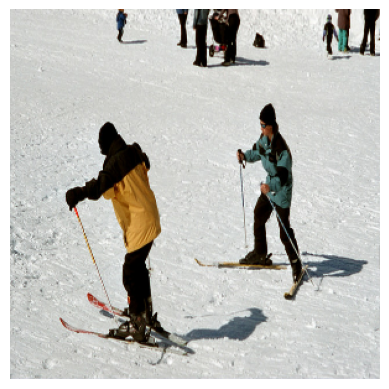

In [69]:
caption_image(test_df["image"][20])
